In [1]:
import os
import pathlib
import math

import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import src.utils.time
import src.utils.dict
import src.utils.comps
import src.utils.module
import src.utils.json

import src.comps.heads_pyramid_2

In [2]:
tab20_color_list =\
    [mpl.colormaps["tab20"](x) for x in (np.linspace(0, 1-1/20, 20) + 1/(2*20))[0::2]] +\
    [mpl.colormaps["tab20"](x) for x in (np.linspace(0, 1-1/20, 20) + 1/(2*20))[1::2]]

---

In [3]:
exp_data_all = {}

In [4]:
data_subdir_name = "ret_train"
backbone_name = "convnext_t"
exp_name_list = [
    "test_002"
]
    
#

if data_subdir_name not in exp_data_all.keys(): exp_data_all[data_subdir_name] = {}
exp_data_all[data_subdir_name][backbone_name] = {}

exp_dirname = os.path.join(pathlib.Path.home(), "data", "fashion_retrieval", data_subdir_name, backbone_name)

for exp_name in exp_name_list:

    exp_filename = os.path.join(exp_dirname, exp_name, "exp_data.json")
    exp_data = src.utils.json.load_json_dict(exp_filename)

    exp_data_all[data_subdir_name][backbone_name][exp_name] = exp_data

In [7]:
data_subdir_name = "ret_train_old_smpl_2"
backbone_name = "convnext_t_s2"
exp_name_list =\
    ["head_{:03d}_exp_{:03d}".format(head_idx, exp_idx) for head_idx in [0] for exp_idx in [0, 1, 2]] +\
    ["head_{:03d}_exp_{:03d}".format(head_idx, exp_idx) for head_idx in [6] for exp_idx in [0, 1, 2]] +\
    ["head_{:03d}_exp_{:03d}".format(head_idx, exp_idx) for head_idx in [7] for exp_idx in [0, 1, 2]] +\
    ["head_{:03d}_exp_{:03d}".format(head_idx, exp_idx) for head_idx in [8] for exp_idx in [0, 1, 2]] +\
    ["head_{:03d}_exp_{:03d}".format(head_idx, exp_idx) for head_idx in [9] for exp_idx in [0, 1, 2]] +\
    ["head_{:03d}_exp_{:03d}".format(head_idx, exp_idx) for head_idx in [10] for exp_idx in [0, 1, 2]] +\
    ["head_{:03d}_exp_{:03d}".format(head_idx, exp_idx) for head_idx in [11] for exp_idx in [0, 1, 2]]

#

if data_subdir_name not in exp_data_all.keys(): exp_data_all[data_subdir_name] = {}
exp_data_all[data_subdir_name][backbone_name] = {}

exp_dirname = os.path.join(pathlib.Path.home(), "data", "fashion_retrieval", data_subdir_name, backbone_name)

for exp_name in exp_name_list:

    exp_filename = os.path.join(exp_dirname, exp_name, "train_ret_DDP_stage_2__data.json")
    exp_data = src.utils.json.load_json_dict(exp_filename)

    exp_data_all[data_subdir_name][backbone_name][exp_name] = exp_data

In [8]:
exp_data_all.keys()

dict_keys(['ret_train', 'ret_train_old_smpl_2'])

In [9]:
exp_data_all["ret_train"].keys()

dict_keys(['convnext_t'])

In [10]:
exp_data_all["ret_train_old_smpl_2"].keys()

dict_keys(['convnext_t_s2'])

---

In [15]:
def plot_losses(
    exp_name_list,
    exp_data_list,
    head_idx,
    num_epochs=5
):

    fig, axs = plt.subplots(nrows=2, figsize=(20, 12))

    # Baseline

    exp_data = exp_data_all["ret_train"]["convnext_t"]["test_002"]

    train_loss_list = [sum(l) for l in exp_data["results"]["stage_2"]["train_mean_loss_list"]][:num_epochs]
    val_loss_list = [sum(l) for l in exp_data["results"]["stage_2"]["val_mean_loss_list"]][:num_epochs]

    finished = exp_data["results"]["stage_1"]["finished"]

    label = "Baseline"

    axs[0].plot(range(1, len(train_loss_list) + 1), train_loss_list, label=label, color="black", marker=".", linestyle="--")
    axs[1].plot(range(1, len(val_loss_list) + 1), val_loss_list, label=label, color="black", marker=".", linestyle="--")

    #print("{:20s} | {:s}".format(label, np.format_float_scientific(val_loss_list[-1], precision=6, exp_digits=1)))

    #print("Baseline", ":", val_loss_list)

    # Experiments ret_train_old_smpl/convnext_v2_t_s1

    for exp_name, exp_data in zip(exp_name_list, exp_data_list):

        # Load data

        train_loss_list = [sum(l) for l in exp_data["results"]["stage_2"]["train_mean_loss_list"]]
        val_loss_list = [sum(l) for l in exp_data["results"]["stage_2"]["val_mean_loss_list"]]

        train_loss_list = train_loss_list[:min(num_epochs, len(train_loss_list))]
        val_loss_list = val_loss_list[:min(num_epochs, len(val_loss_list))]

        finished = exp_data["results"]["stage_2"]["finished"]
        base_lr = exp_data["settings"]["stage_2"]["optimizer"]["lr"]

        head_class = exp_data["settings"]["head"]["class"]
        head_order = "BU" if "BottomUp" in head_class else "TD"
        head_speed = "Inst" if "Instant" in head_class else "Prog"
        head_du_mode = "Simple" if "Simple" in head_class else "Conv"
        if head_speed == "Prog":
            head_weight = "Early" if exp_data["settings"]["head"]["emb_sizes"][0] == 512 else "Late"
        else:
            head_weight = ""

        # Title

        title_lines = []    
        title_lines.append("{:s}".format(exp_name))
        if math.isnan(train_loss_list[-1]):
            title_lines[-1] += " | NAN"
        elif not finished:
            title_lines[-1] += " | Unifinished"
        title_lines.append("ConvNeXt-T")
        title_lines.append("{:2s} {:4s} {:6s} {:5s}".format(
            head_order,
            head_speed,
            head_du_mode,
            head_weight
        ))
        title_lines.append("LR: {:s}".format(np.format_float_scientific(base_lr, min_digits=2, exp_digits=1)))

        label = "\n".join(title_lines)

        
        # Plot

        axs[0].plot(range(1, len(train_loss_list) + 1), train_loss_list, label=label, marker=".")
        axs[1].plot(range(1, len(val_loss_list) + 1), val_loss_list, label=label, marker=".")

    # Generic settings

    axs[0].set_yscale("log")
    axs[1].set_yscale("log")

    axs[0].grid()
    axs[1].grid()

    axs[0].set_title("Train loss")
    axs[1].set_title("Val loss")

    plt.suptitle("Head {:d}".format(head_idx))
    plt.legend(prop={'family': 'monospace', "size": 13}, bbox_to_anchor=(1.20, 2.00))
    plt.show()

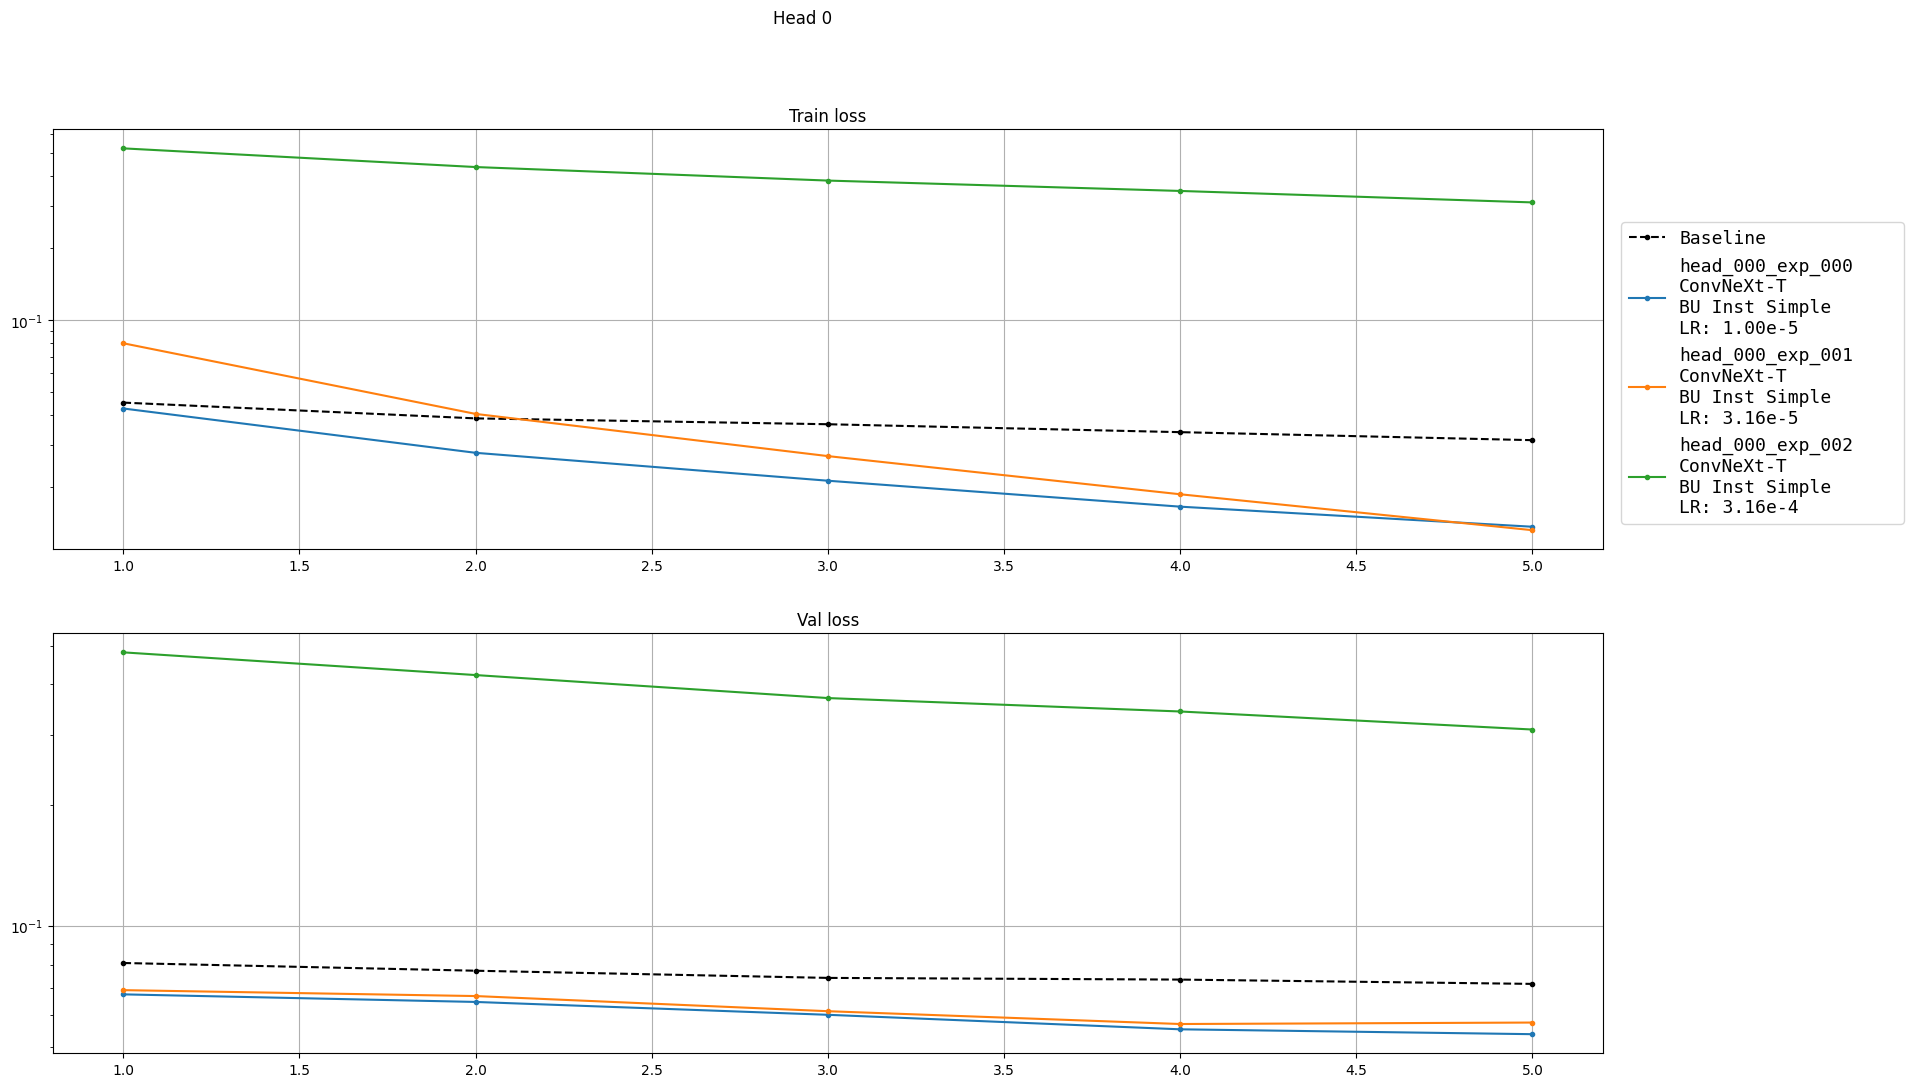

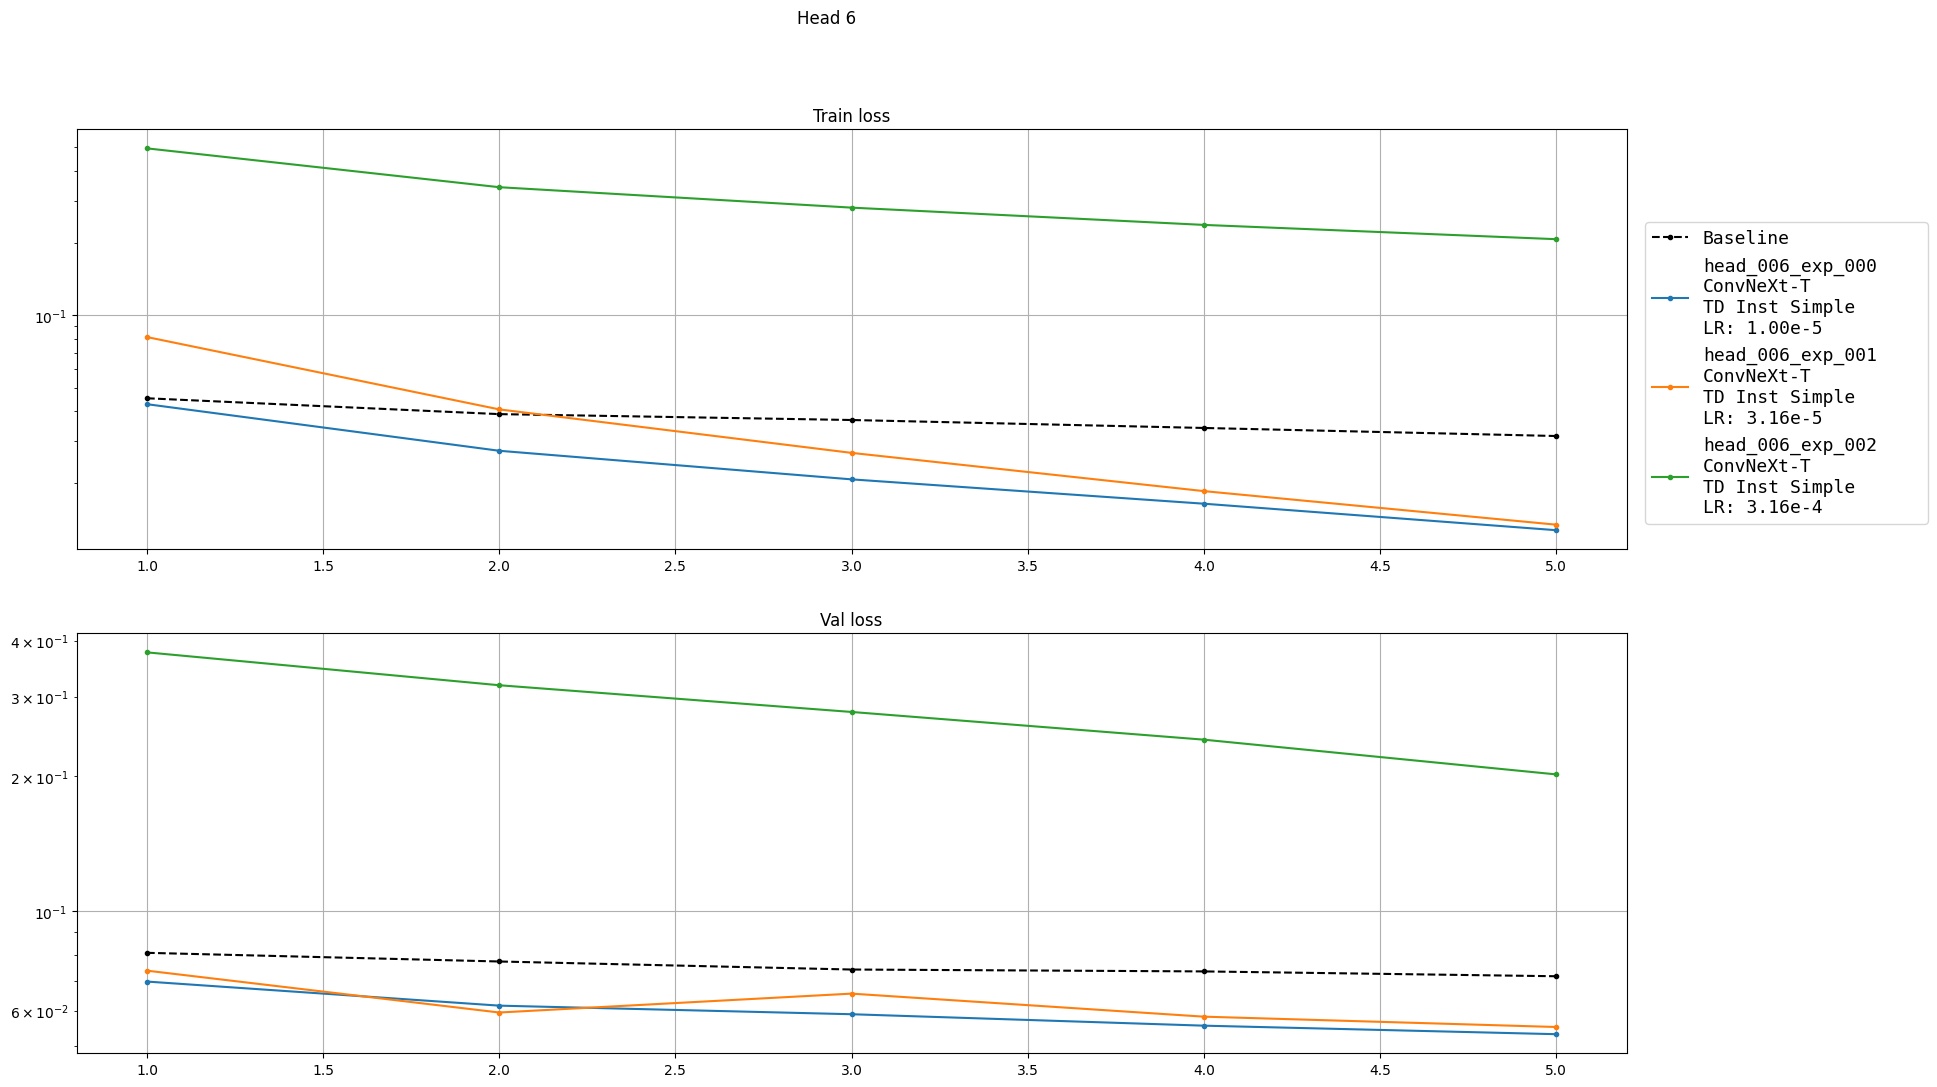

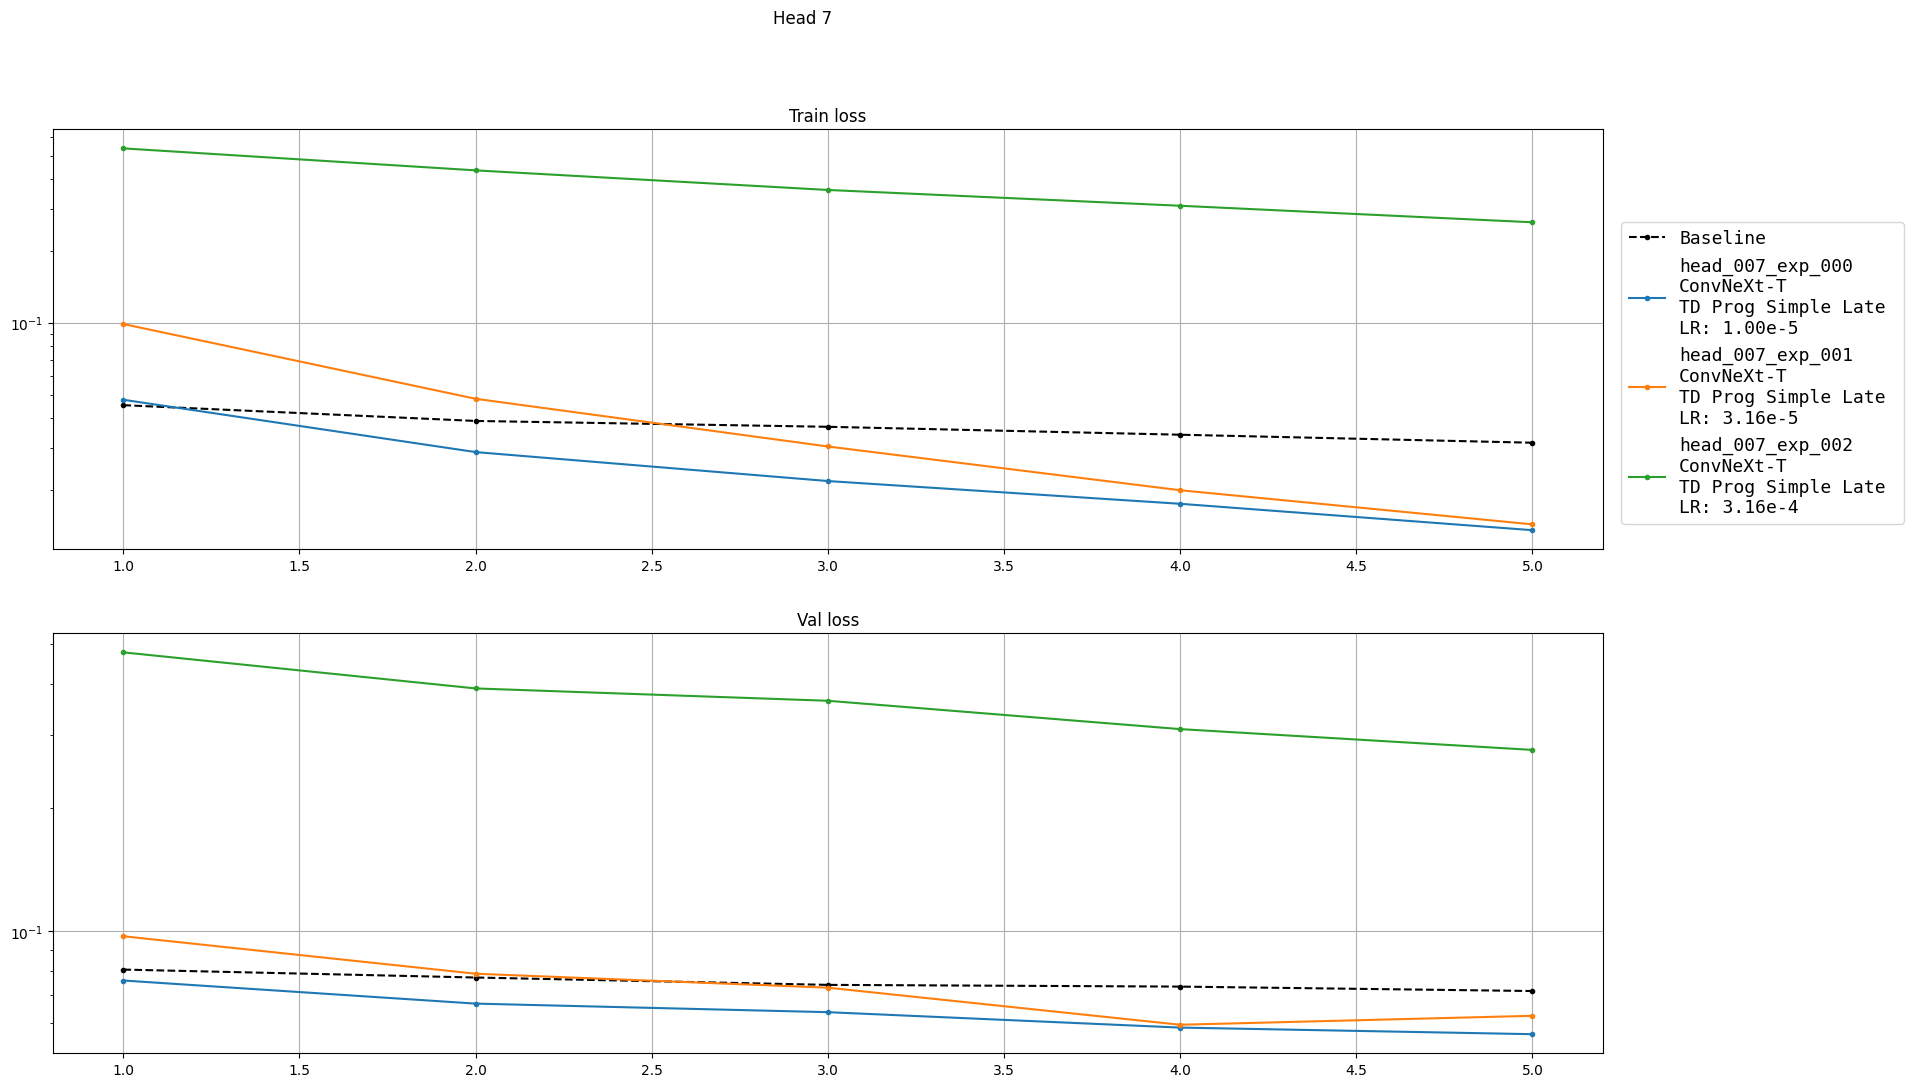

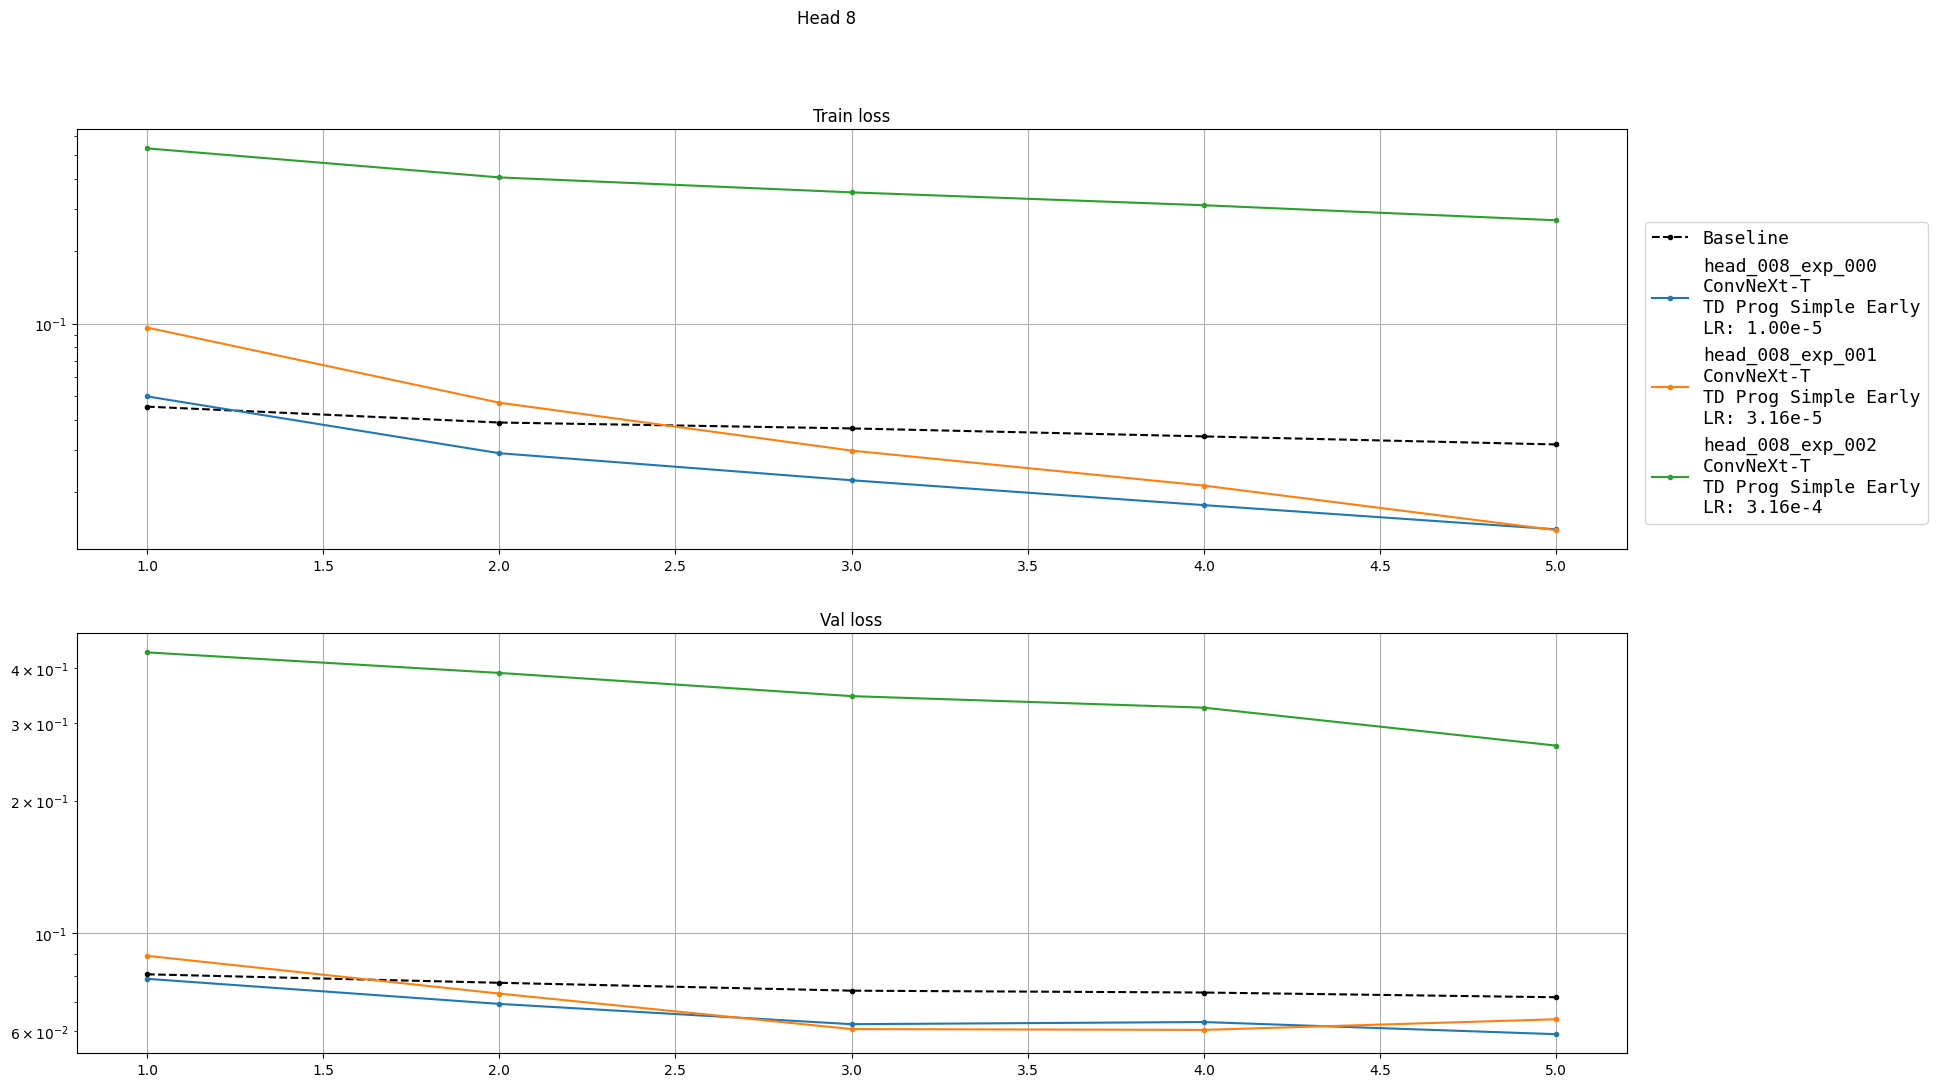

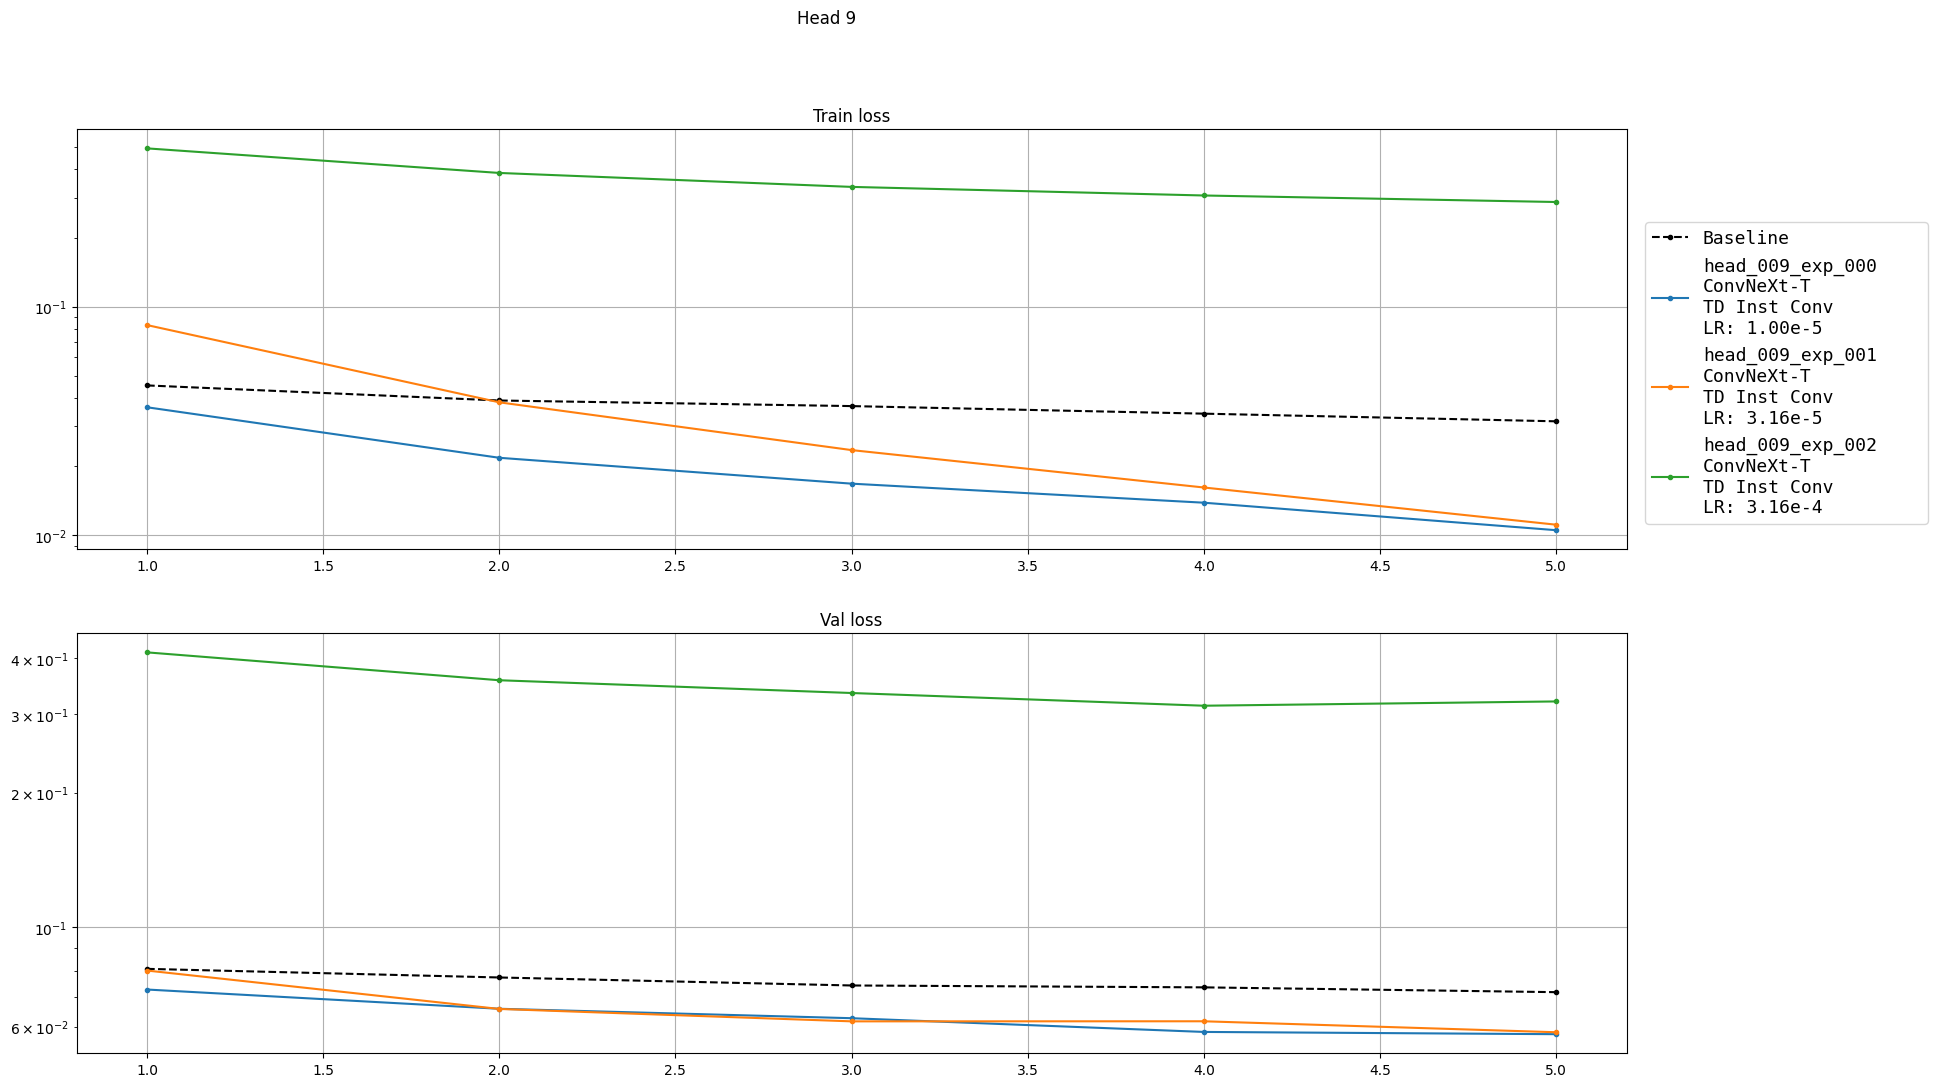

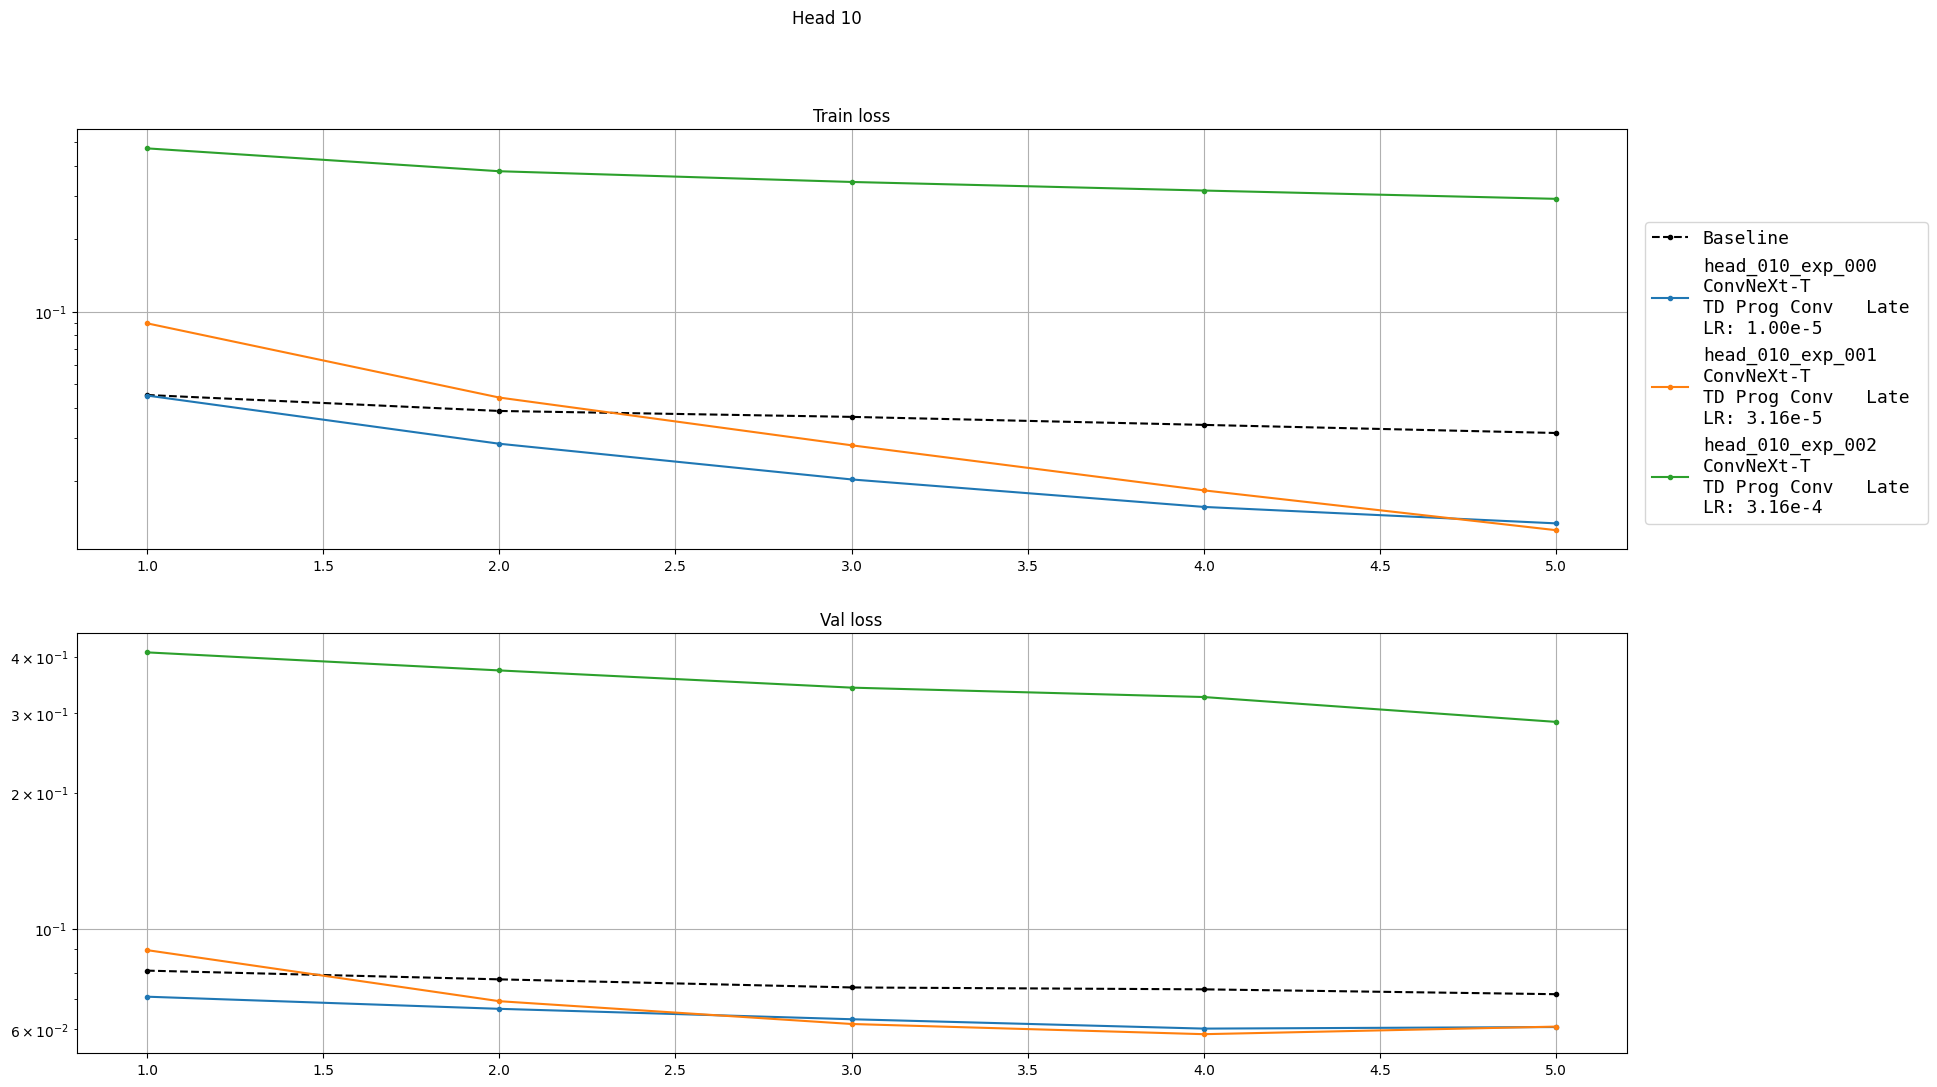

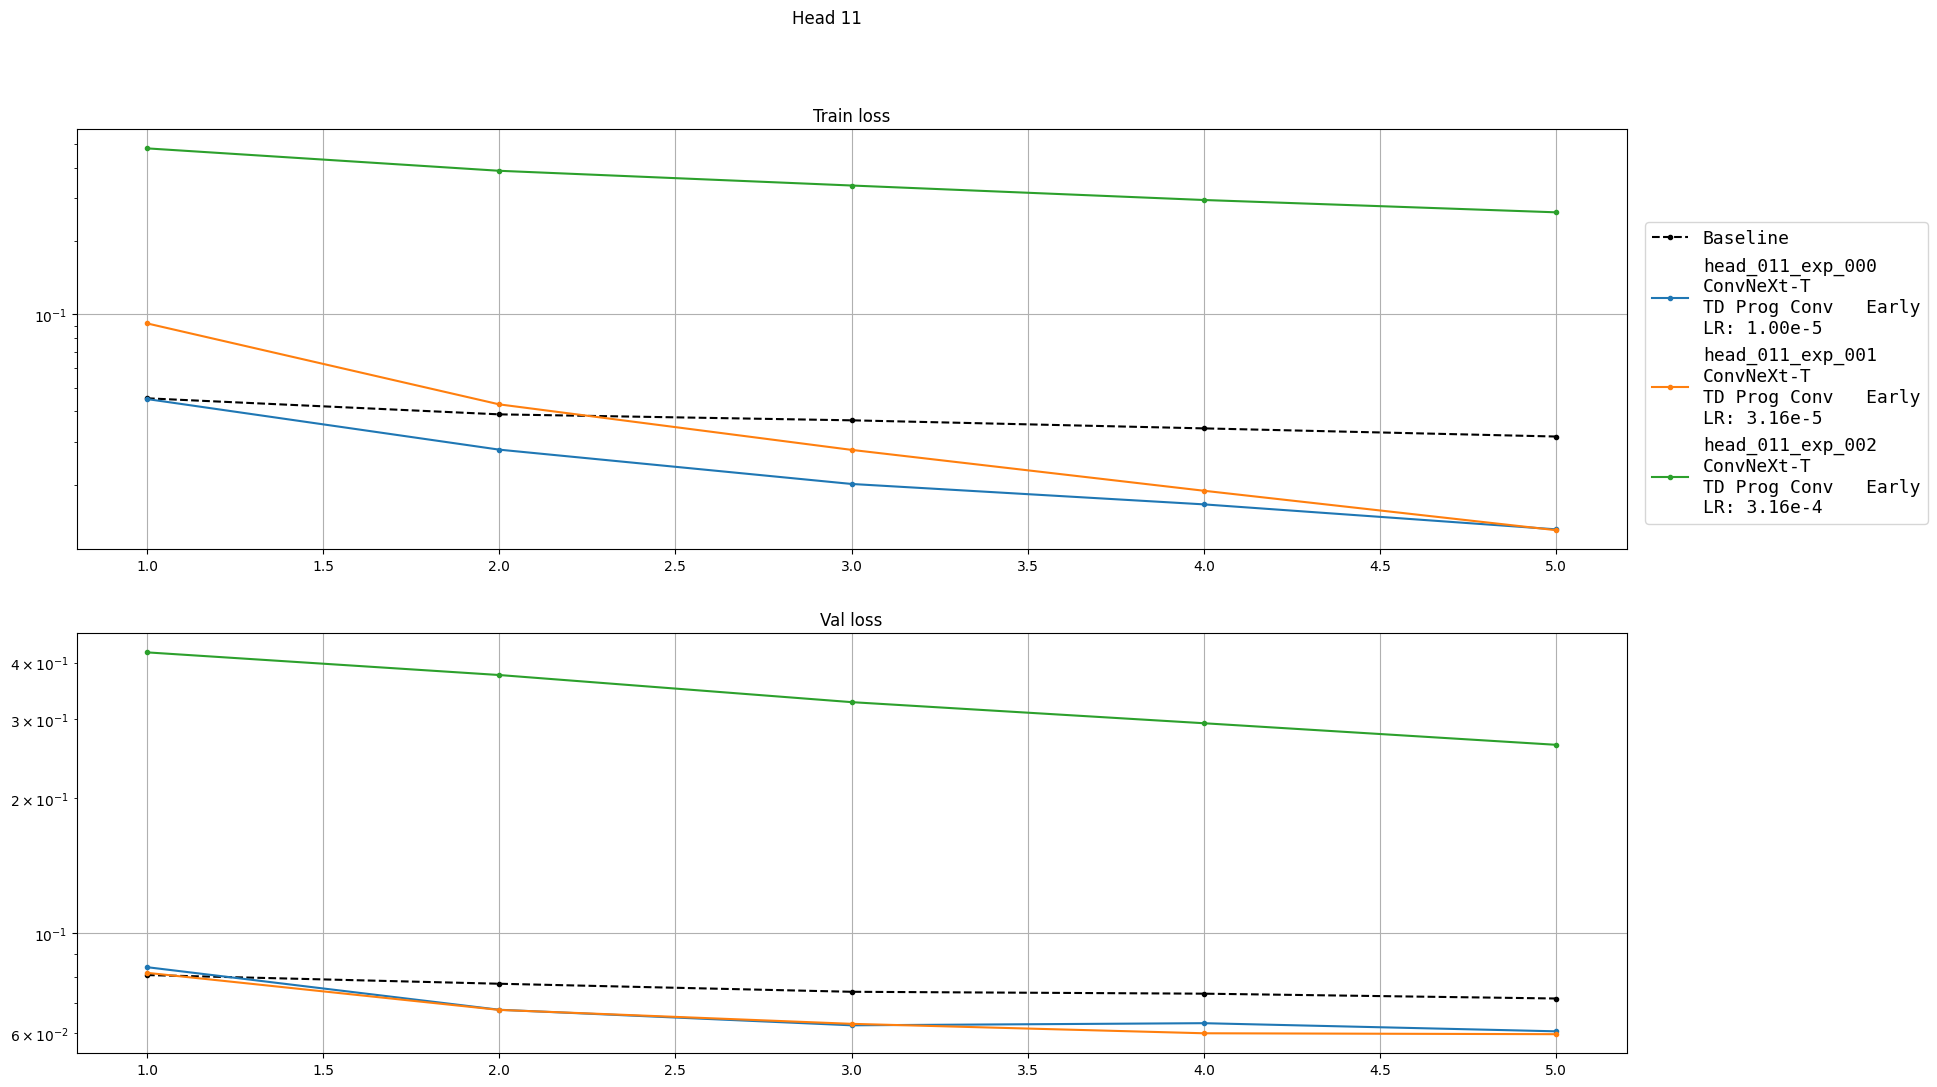

In [16]:
for desired_head_num in [0, 6, 7, 8, 9, 10, 11]:

    exp_name_list = []
    exp_data_list = []

    for exp_name, exp_data in exp_data_all["ret_train_old_smpl_2"]["convnext_t_s2"].items():
        tkns = exp_name.split("_")
        head_num = int(tkns[1])
        exp_num = int(tkns[3])
        if head_num == desired_head_num:
            exp_name_list.append(exp_name)
            exp_data_list.append(exp_data)

    plot_losses(
        exp_name_list,
        exp_data_list,
        desired_head_num,
        num_epochs=5 if desired_head_num in [1, 2] else 5
    )

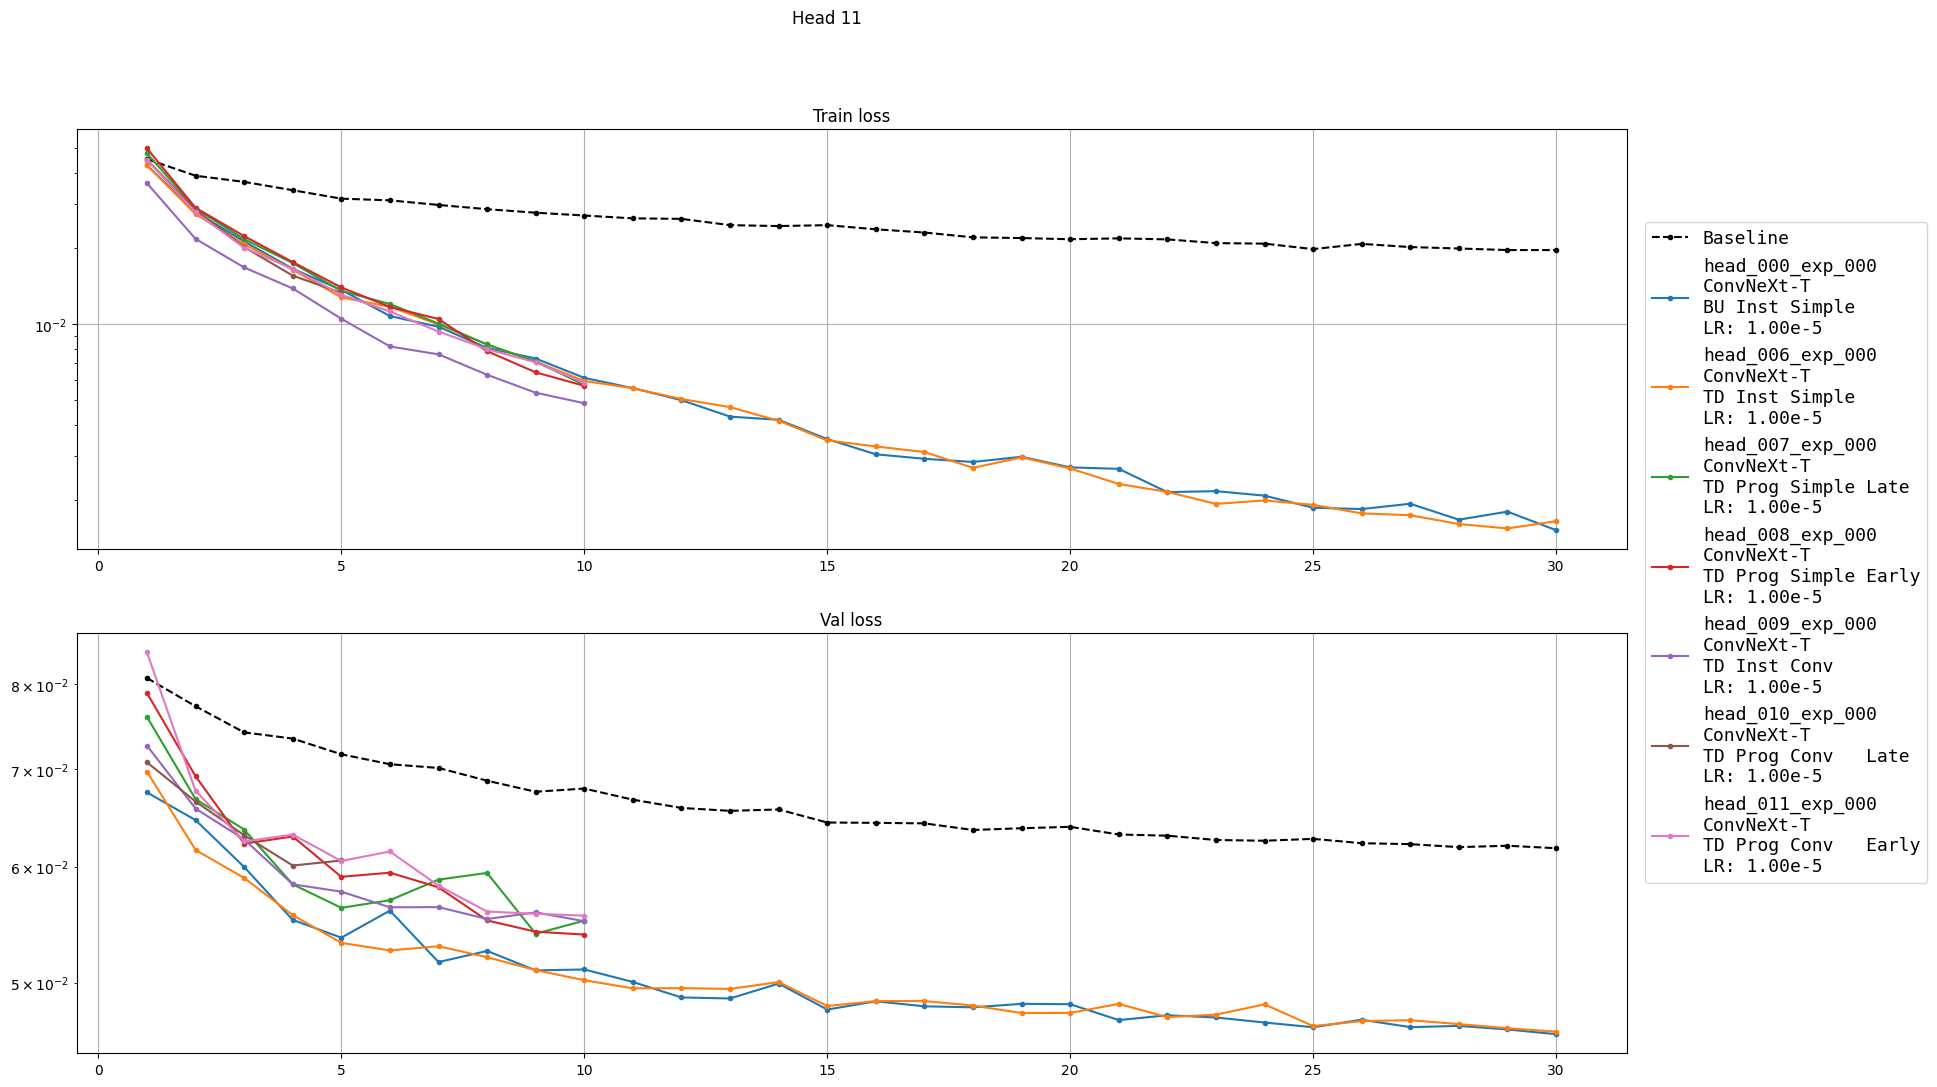

In [17]:
desired_exp_name_list = [
    "head_000_exp_000",
    "head_006_exp_000",
    "head_007_exp_000",
    "head_008_exp_000",
    "head_009_exp_000",
    "head_010_exp_000",
    "head_011_exp_000"
]

exp_name_list = []
exp_data_list = []

for exp_name, exp_data in exp_data_all["ret_train_old_smpl_2"]["convnext_t_s2"].items():
    if exp_name in desired_exp_name_list:
        exp_name_list.append(exp_name)
        exp_data_list.append(exp_data)

plot_losses(
    exp_name_list,
    exp_data_list,
    desired_head_num,
    num_epochs=30
)

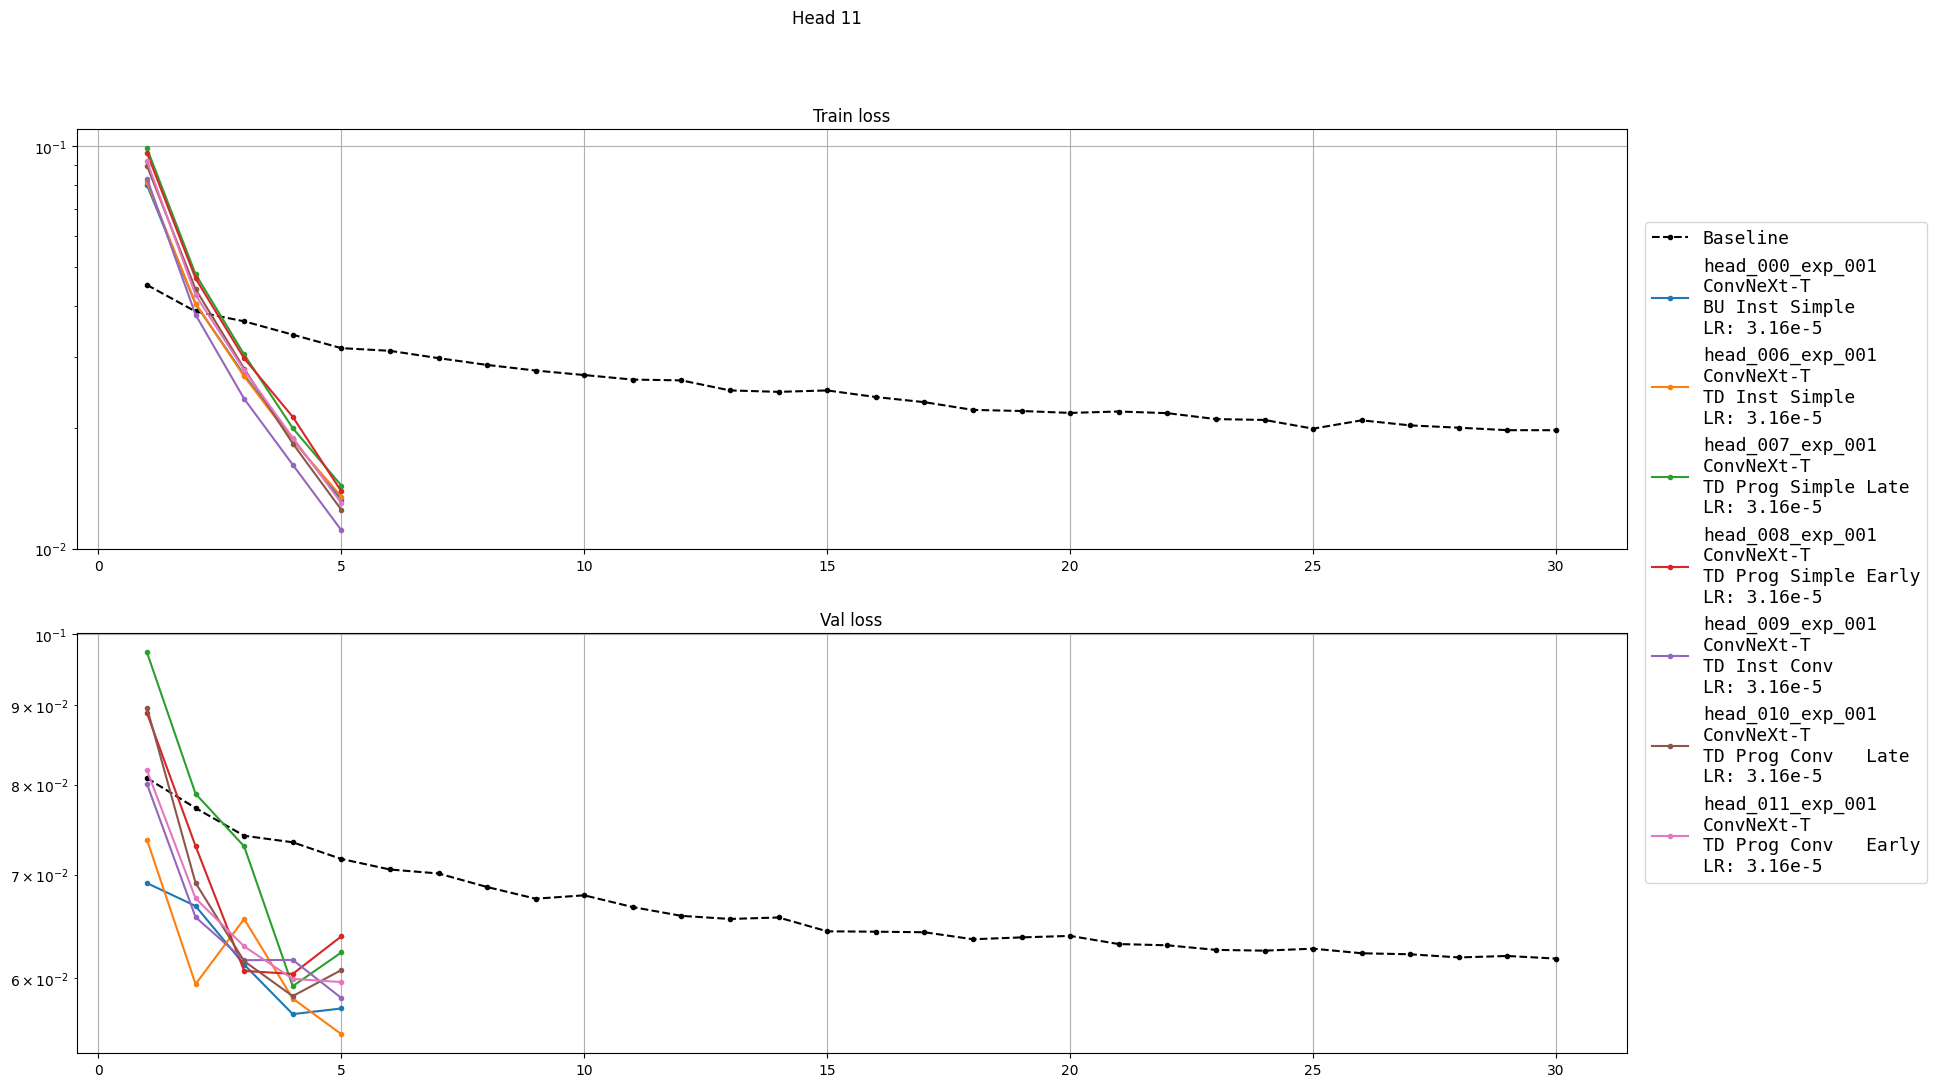

In [22]:
desired_exp_name_list = [
    "head_000_exp_001",
    "head_006_exp_001",
    "head_007_exp_001",
    "head_008_exp_001",
    "head_009_exp_001",
    "head_010_exp_001",
    "head_011_exp_001"
]

exp_name_list = []
exp_data_list = []

for exp_name, exp_data in exp_data_all["ret_train_old_smpl_2"]["convnext_t_s2"].items():
    if exp_name in desired_exp_name_list:
        exp_name_list.append(exp_name)
        exp_data_list.append(exp_data)

plot_losses(
    exp_name_list,
    exp_data_list,
    desired_head_num,
    num_epochs=30
)

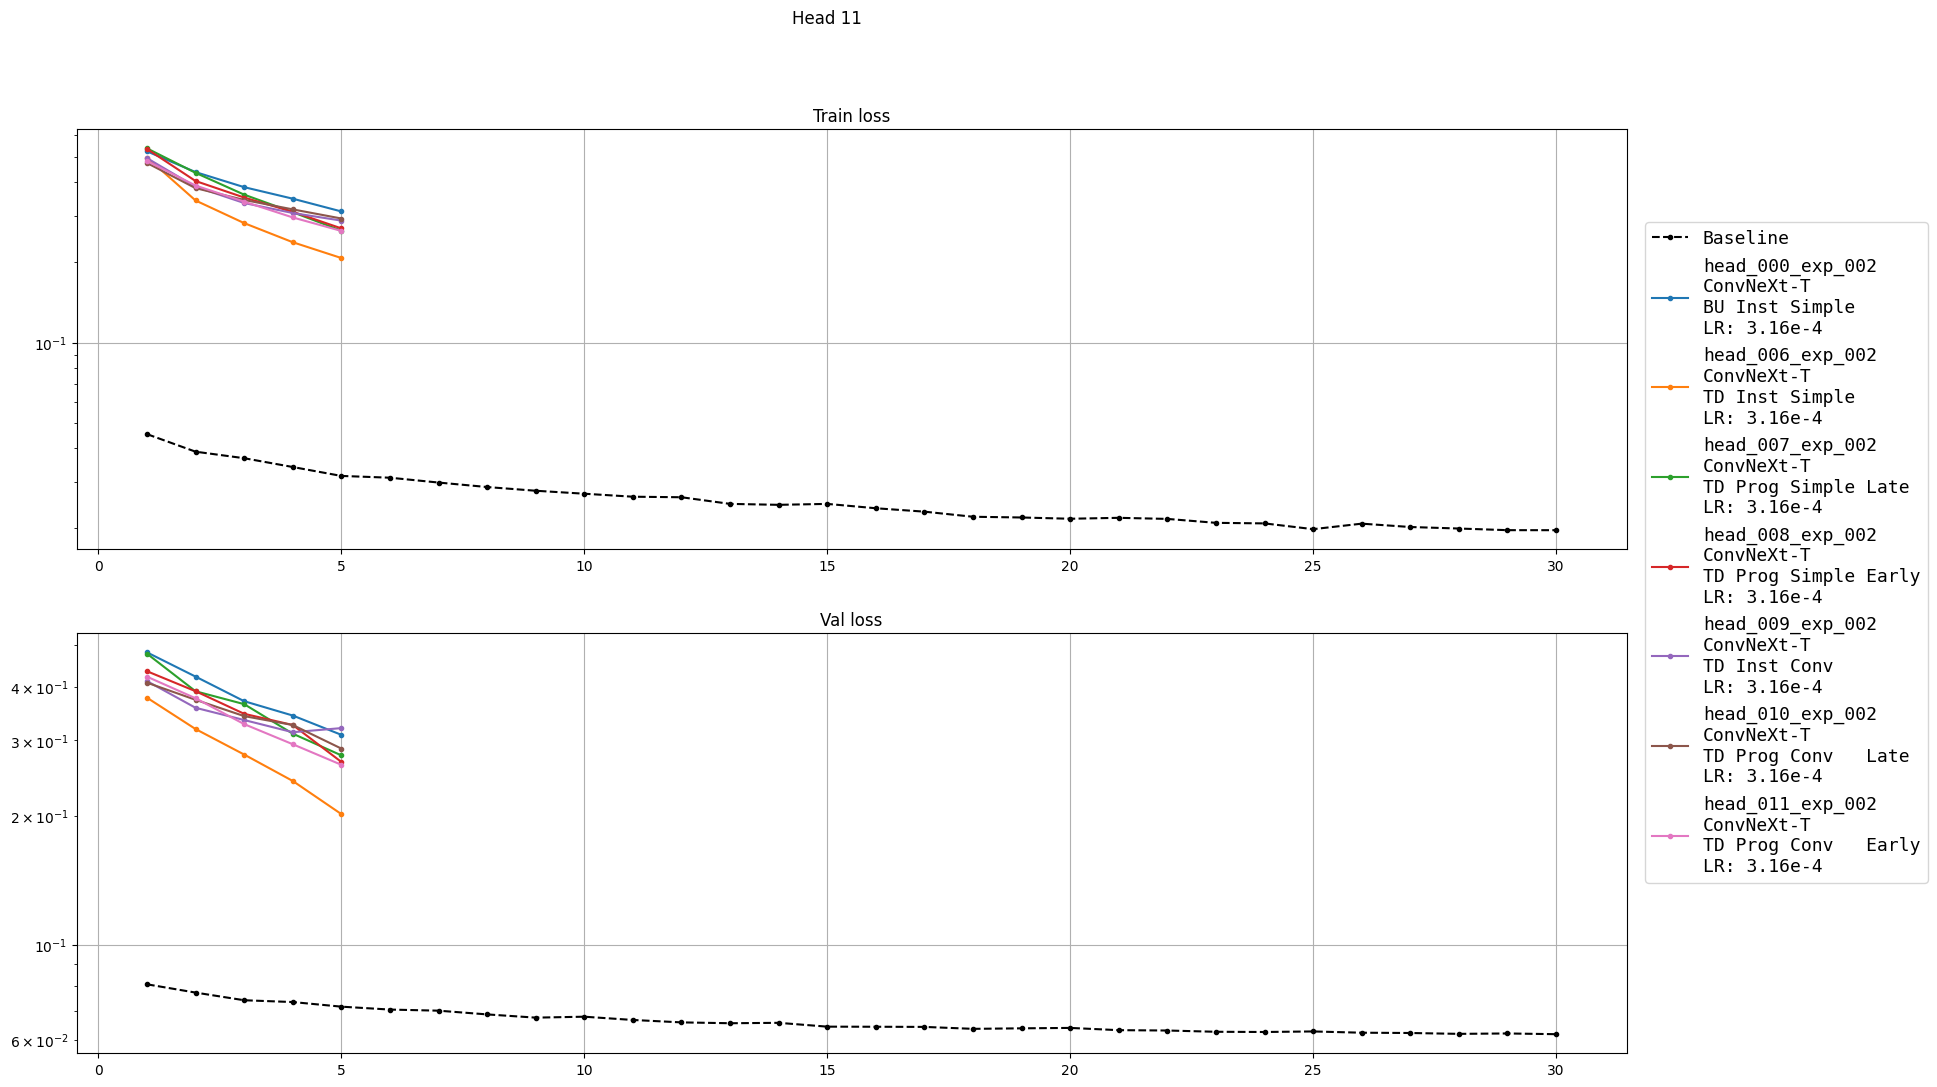

In [23]:
desired_exp_name_list = [
    "head_000_exp_002",
    "head_006_exp_002",
    "head_007_exp_002",
    "head_008_exp_002",
    "head_009_exp_002",
    "head_010_exp_002",
    "head_011_exp_002"
]

exp_name_list = []
exp_data_list = []

for exp_name, exp_data in exp_data_all["ret_train_old_smpl_2"]["convnext_t_s2"].items():
    if exp_name in desired_exp_name_list:
        exp_name_list.append(exp_name)
        exp_data_list.append(exp_data)

plot_losses(
    exp_name_list,
    exp_data_list,
    desired_head_num,
    num_epochs=30
)

---

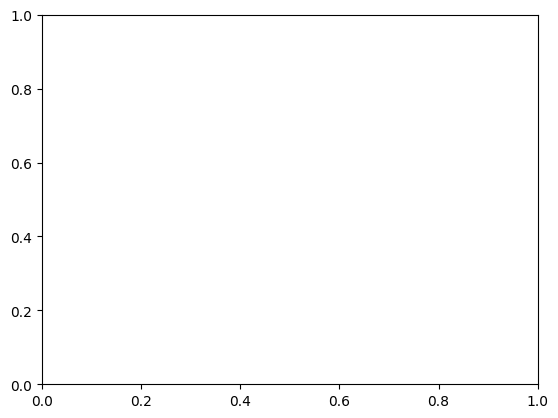

In [18]:
def plot_lr_study(
    exp_name_list,
    exp_data_list,
    split,
    epoch_num=5,
    plot_size=8,
    log_x_margin=0.05,
    log_y_margin=0.05,
    ax=plt.gca()
):

    # Baseline

    exp_data = exp_data_all["ret_train"]["convnext_t"]["test_002"]

    train_loss_list = [sum(l) for l in exp_data["results"]["stage_2"]["train_mean_loss_list"]]
    val_loss_list = [sum(l) for l in exp_data["results"]["stage_2"]["val_mean_loss_list"]]

    if split == "train":
        loss_list = train_loss_list
    else:
        loss_list = val_loss_list
        #print("Baseline", ":", loss_list)

    finished = exp_data["results"]["stage_1"]["finished"]

    label = "Baseline"

    epoch_num_corr = min(len(loss_list), epoch_num)
    ax.axhline(loss_list[epoch_num_corr-1], color="black", linestyle="--")

    # Plot

    init_lr_list = []
    final_loss_list = []
    epoch_num_corr_list = []

    bad_init_lr_list = []

    for exp_idx, (exp_name, exp_data) in enumerate(zip(exp_name_list, exp_data_list)):

        if split == "train":
            loss_list = [sum(l) for l in exp_data["results"]["stage_2"]["train_mean_loss_list"]]
        else:
            loss_list = [sum(l) for l in exp_data["results"]["stage_2"]["val_mean_loss_list"]]
            #print(exp_name, ":", loss_list)

        if math.isnan(loss_list[-1]):
            bad_init_lr_list.append(exp_data["settings"]["stage_2"]["optimizer"]["lr"])
        else:
            init_lr_list.append(exp_data["settings"]["stage_2"]["optimizer"]["lr"])
            epoch_num_corr = min(len(loss_list), epoch_num)
            epoch_num_corr_list.append(epoch_num_corr)
            final_loss_list.append(loss_list[epoch_num_corr-1])

    #print("Head")
    #print(init_lr_list)
    #print(final_loss_list)

    ax.scatter(init_lr_list, final_loss_list)

    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.grid(True)

    for init_lr, final_loss, epoch_num_corr in zip(init_lr_list, final_loss_list, epoch_num_corr_list):
        text = "{:s}\nEp {:d}".format(
            np.format_float_scientific(init_lr, min_digits=2, exp_digits=1),
            epoch_num_corr
        )
        ax.text(init_lr, final_loss * (1 + log_y_margin), text, ha="center")

    for bad_init_lr in bad_init_lr_list:
        print(bad_init_lr)
        ax.axvline(bad_init_lr, color="red", linestyle="--")

    ylim = ax.get_ylim()
    ax.set_ylim(ylim[0], ylim[1] * (1 + 2 * log_y_margin))

    xlim = ax.get_xlim()
    ax.set_xlim(xlim[0] / (1 + log_x_margin), xlim[1] * (1 + log_x_margin))
    
    ax.set_xlabel("Stage 1 initial learning rate")
    ax.set_ylabel("Stage 1 epoch {:d} {:s} loss".format(epoch_num_corr, split))

    #print()

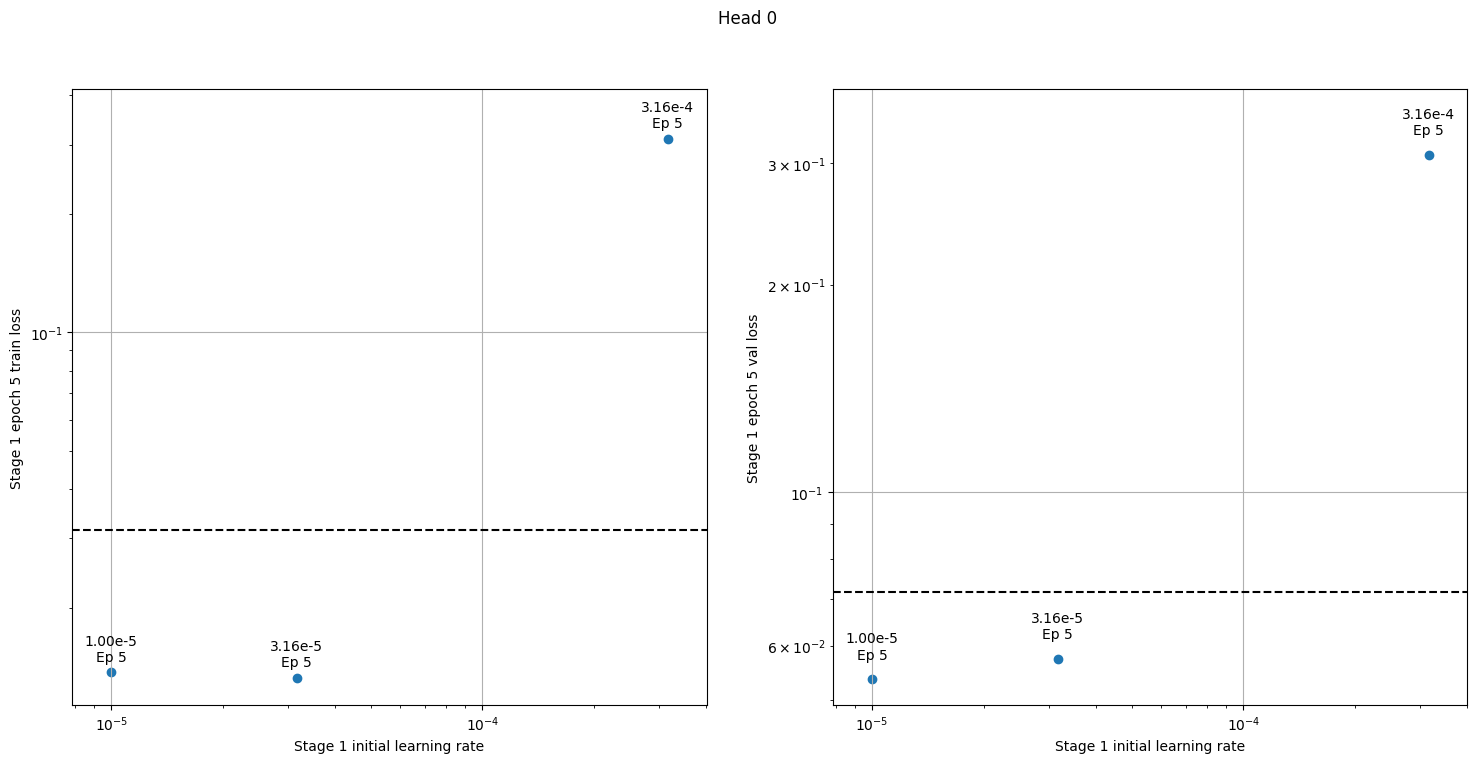

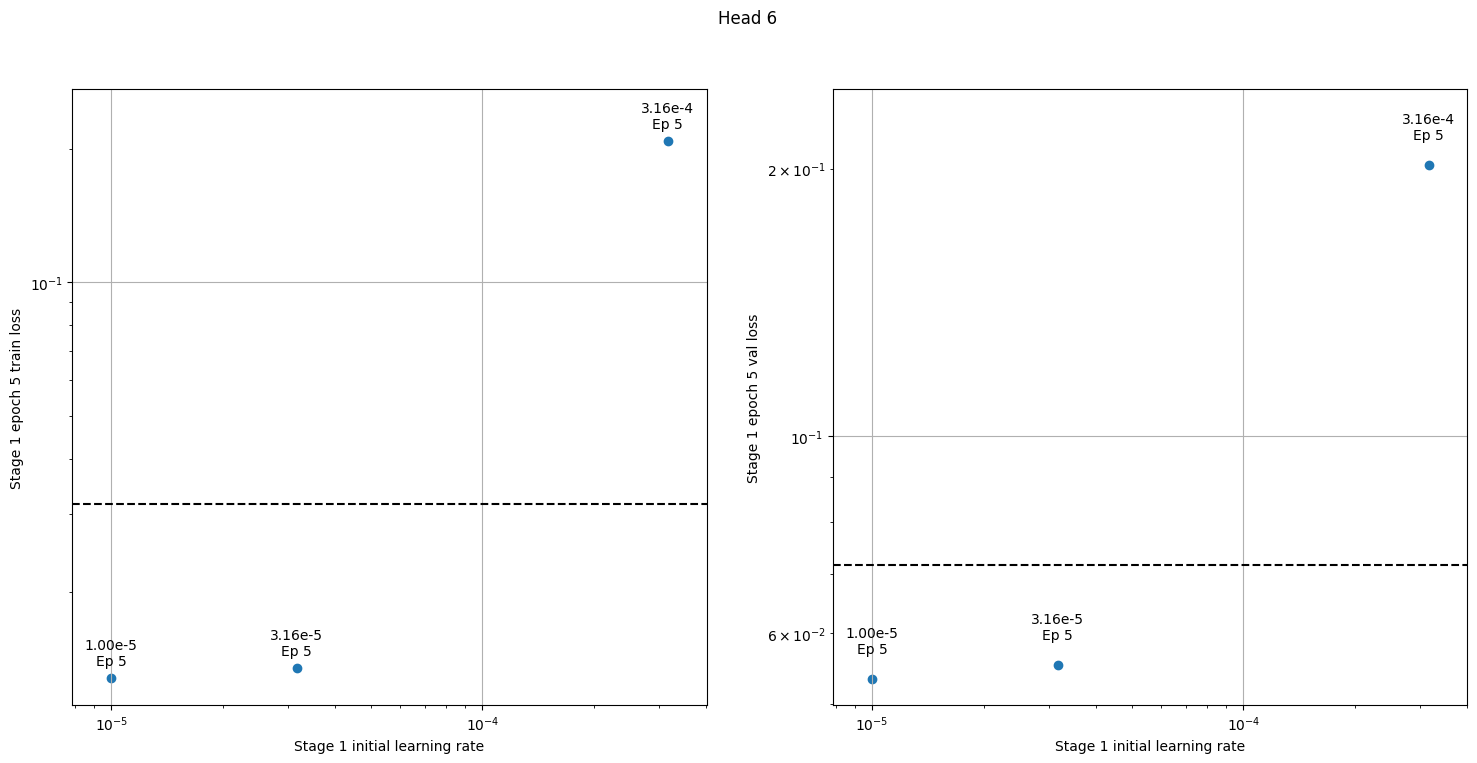

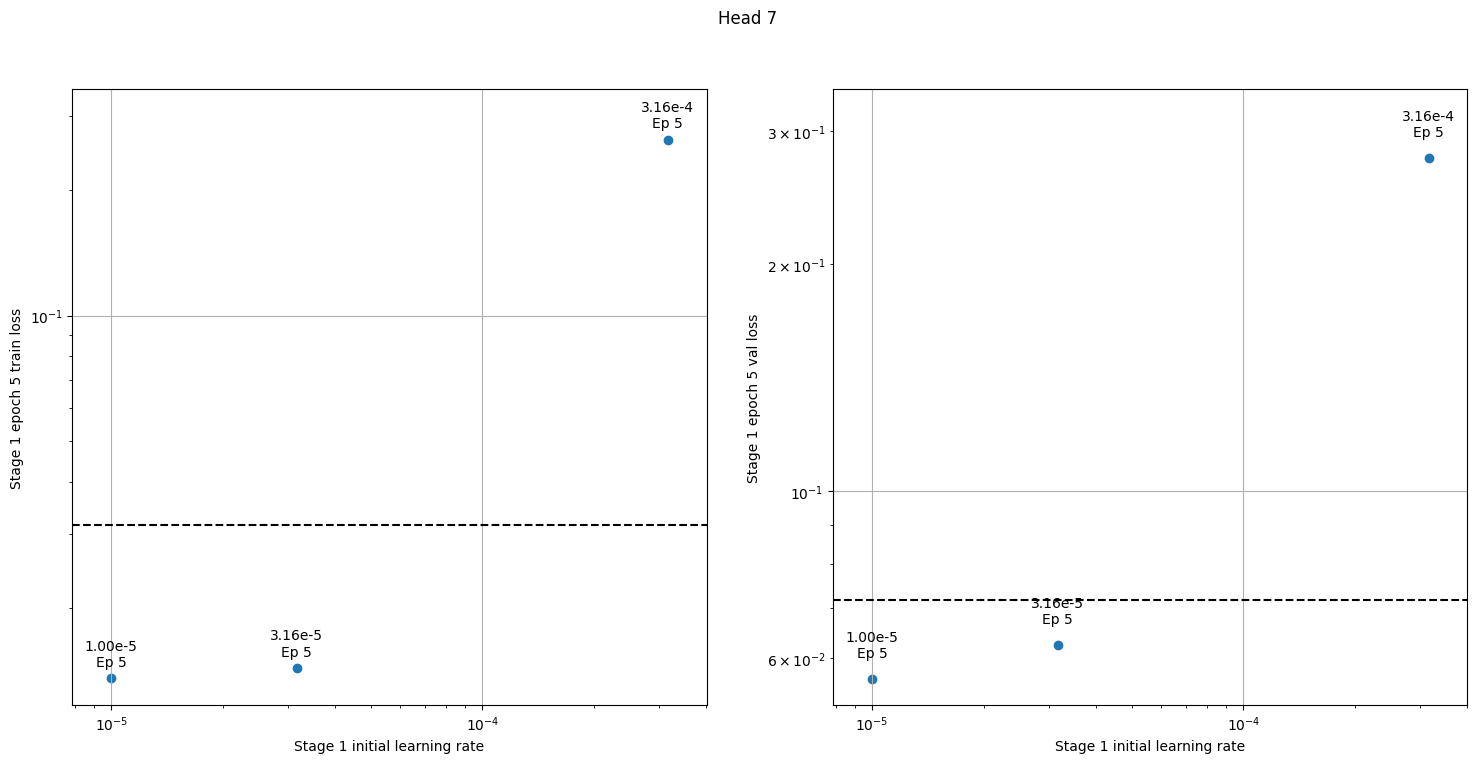

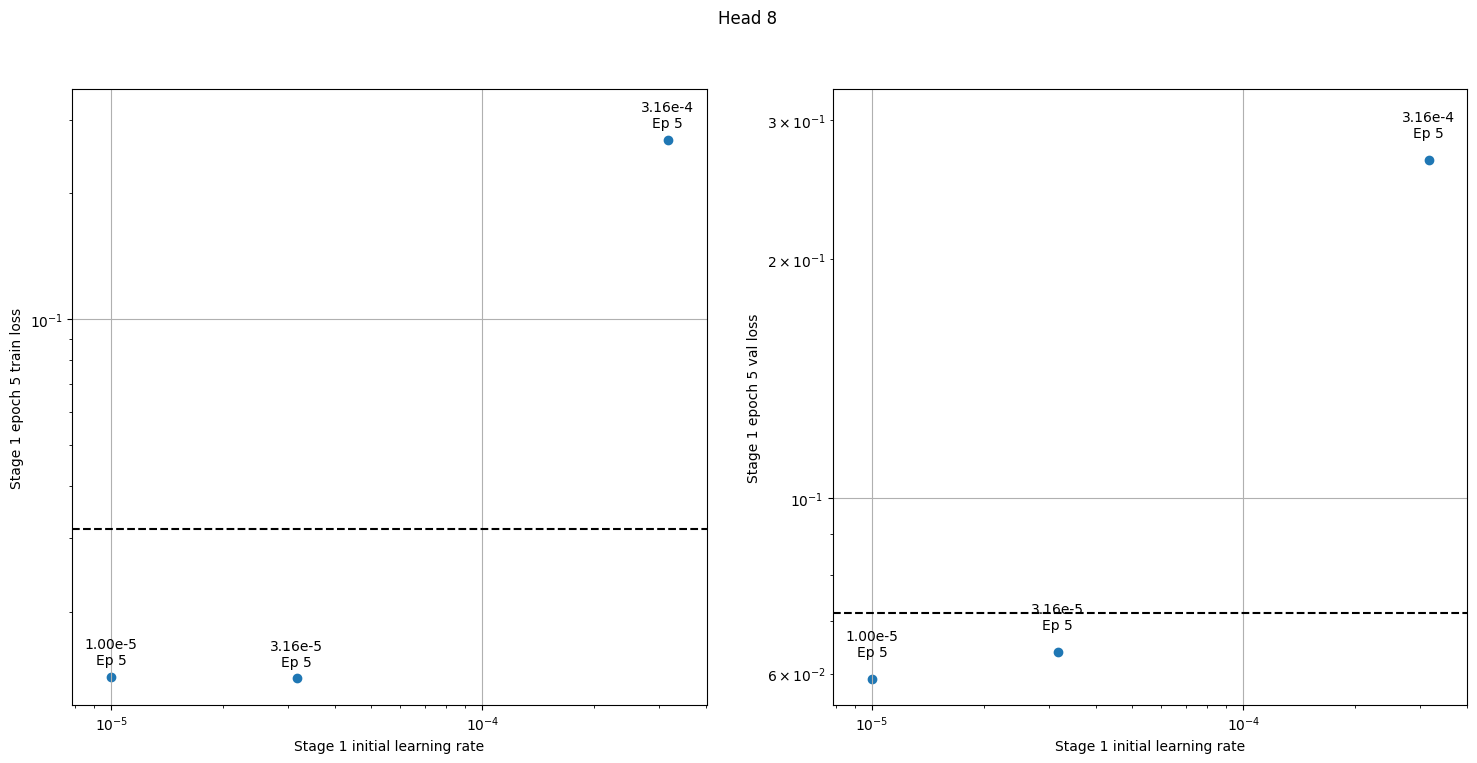

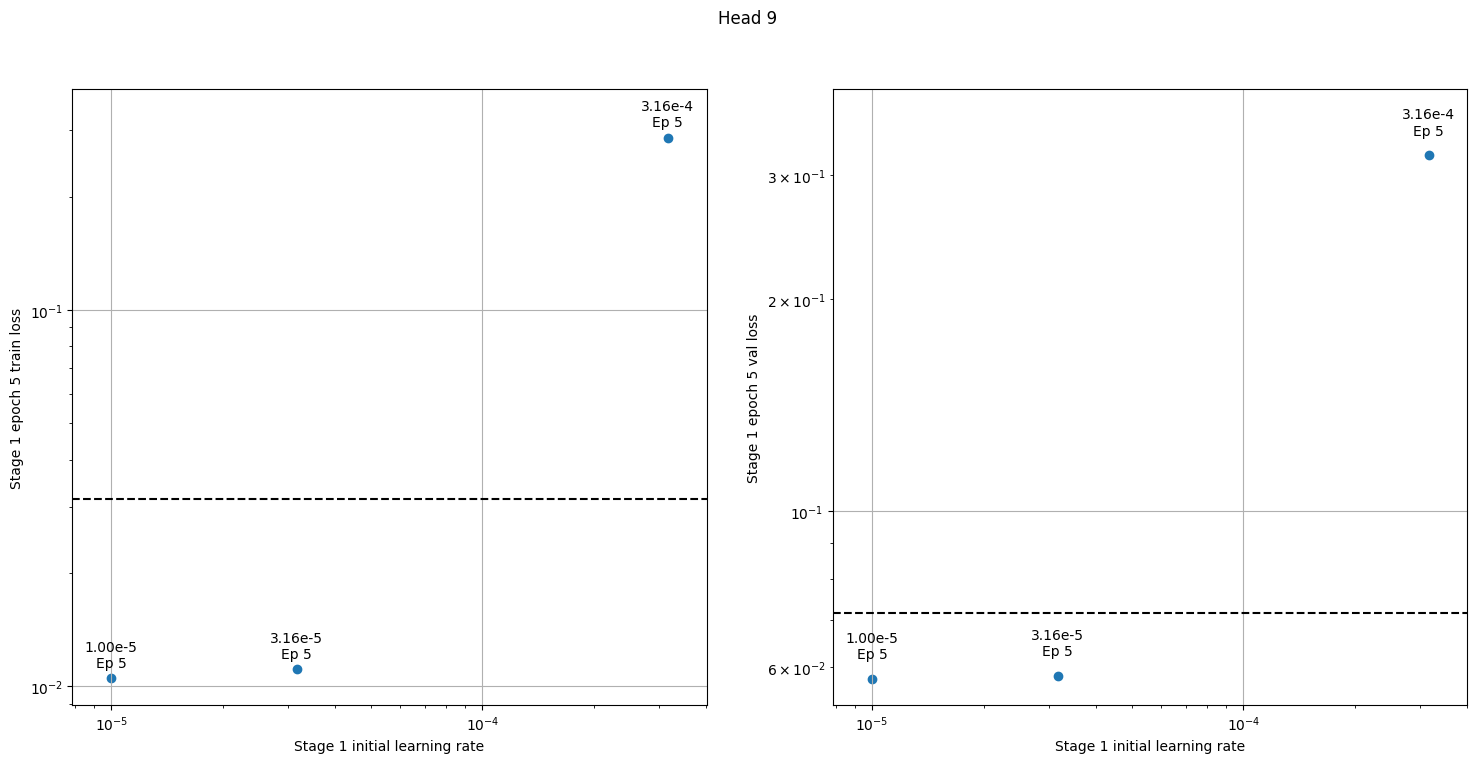

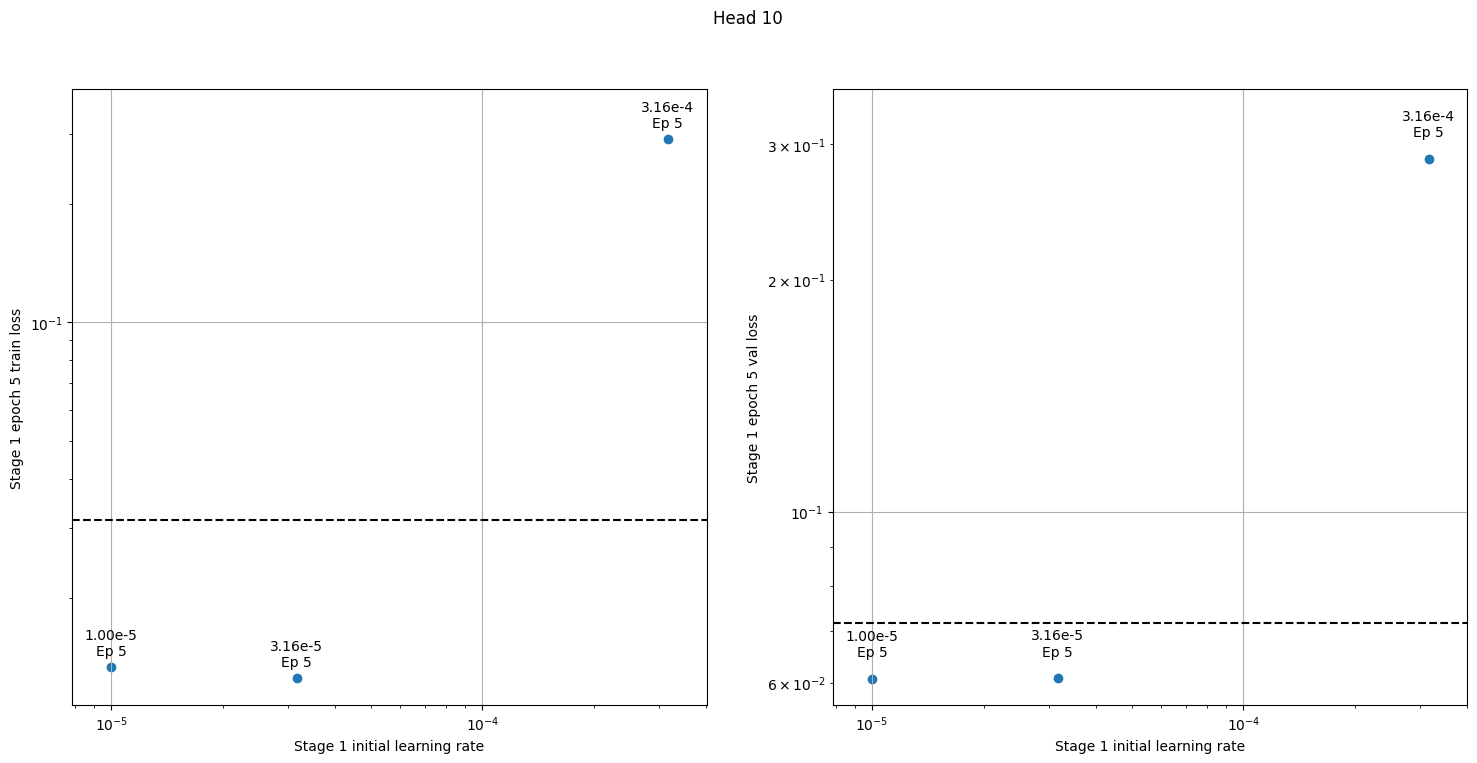

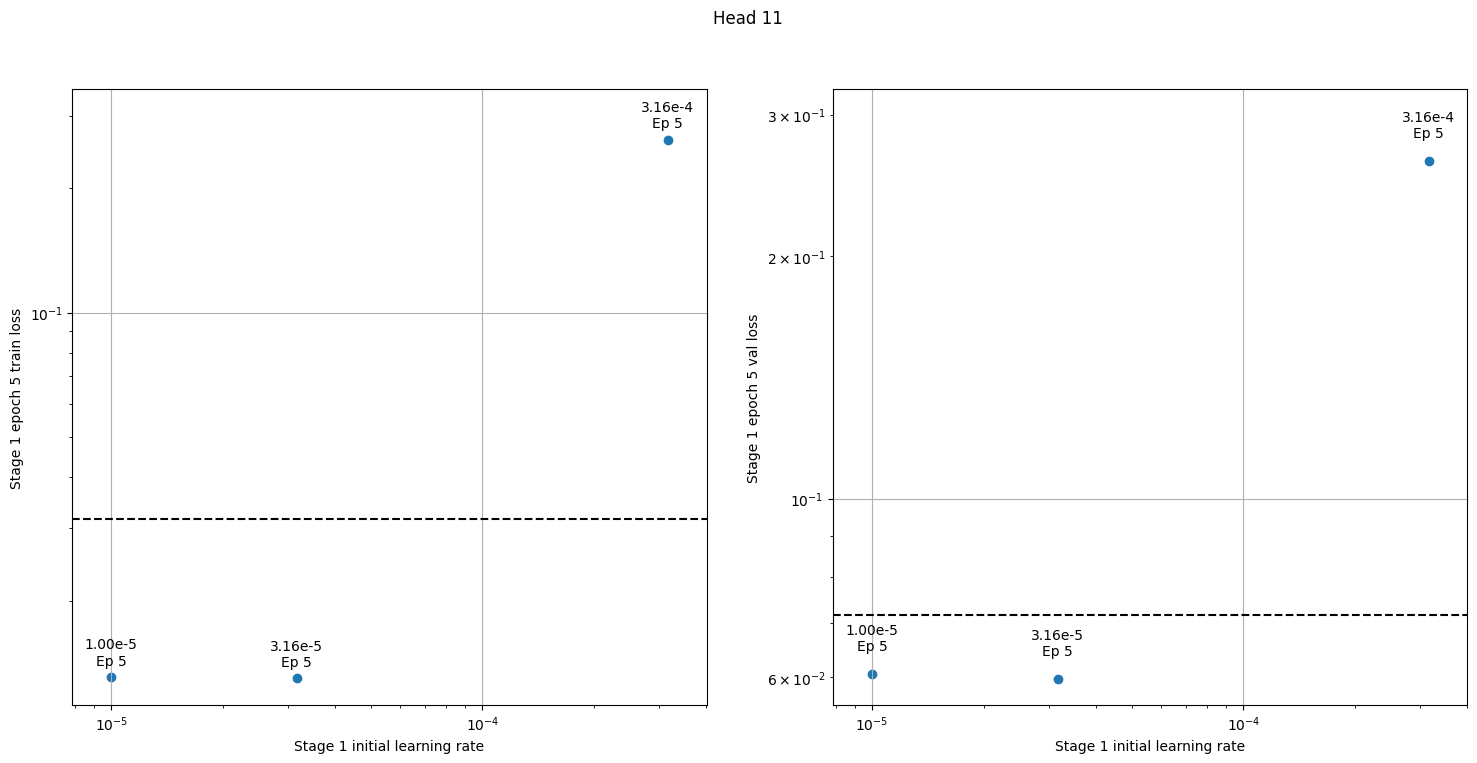

In [21]:
for idx in [0, 6, 7, 8, 9, 10, 11]:

    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18, 8))
    axs = axs.flatten()

    exp_name_list = []
    exp_data_list = []

    for exp_name, exp_data in exp_data_all["ret_train_old_smpl_2"]["convnext_t_s2"].items():
        tkns = exp_name.split("_")
        head_num = int(tkns[1])
        exp_num = int(tkns[3])
        if head_num == idx:
            exp_name_list.append(exp_name)
            exp_data_list.append(exp_data)

    plot_lr_study(
        exp_name_list,
        exp_data_list,
        split="train",
        epoch_num=5,
        log_x_margin=0.07,
        log_y_margin=0.07,
        ax=axs[0]
    )

    plot_lr_study(
        exp_name_list,
        exp_data_list,
        split="val",
        epoch_num=5,
        log_x_margin=0.07,
        log_y_margin=0.07,
        ax=axs[1]
    )

    plt.suptitle("Head {:d}".format(idx))

plt.show()